##Пояснение алгоритма решения:
Для решения поставленной задачи первоначально исследуются исходные данные, после чего алгоритм решения будет следующим:

На первом этапе панорамное изображение разрезается на восемь необходимых частей согласно следующим шагам:

1. Выделите часть крыши на панорамном изображении, используя верхние горизонтальные угловые точки.
2. Выделите часть пола на панорамном изображении, используя нижние горизонтальные угловые точки.
3. Потолок и пол вычитаются из панорамного изображения, чтобы получить изображение, включающее шесть стен, соединенных друг с другом.
4. Определим каждую стену отдельно, используя координаты вертикальных углов, разделяющих стены.

Второй этап включает возврат проекционного изображения каждой части панорамного изображения путем выполнения проекционных операций с размерами, соответствующими реальным размерам лифтового вестибюля, указанным в заданном плане.

##Импорт необходимых библиотек и изучение исходных данных

In [312]:
import cv2
import numpy as np
import json
import pandas as pd
from google.colab.patches import cv2_imshow

In [313]:
panorama_image = cv2.imread("/content/drive/MyDrive/intern_test_3D_room-main/data/image_1024_aligned_rgb.png")
walls_data = pd.DataFrame({
"walls":
{"0": [0, 0, 0, 2050],
"1": [0, 0, 1640, 0],
"2": [1640, 0, 1640, 400],
"3": [1640, 400, 6020, 400],
"4": [ 6020, 400, 6020, 2050],
"5": [0, 2050, 6020, 2050]}
})
corners_vertical = np.load("/content/drive/MyDrive/intern_test_3D_room-main/data/v_corners.npy")
corners_horizontal = np.load("/content/drive/MyDrive/intern_test_3D_room-main/data/h_corners.npy")
depth_map = np.load("/content/drive/MyDrive/intern_test_3D_room-main/data/depth_map.npy")


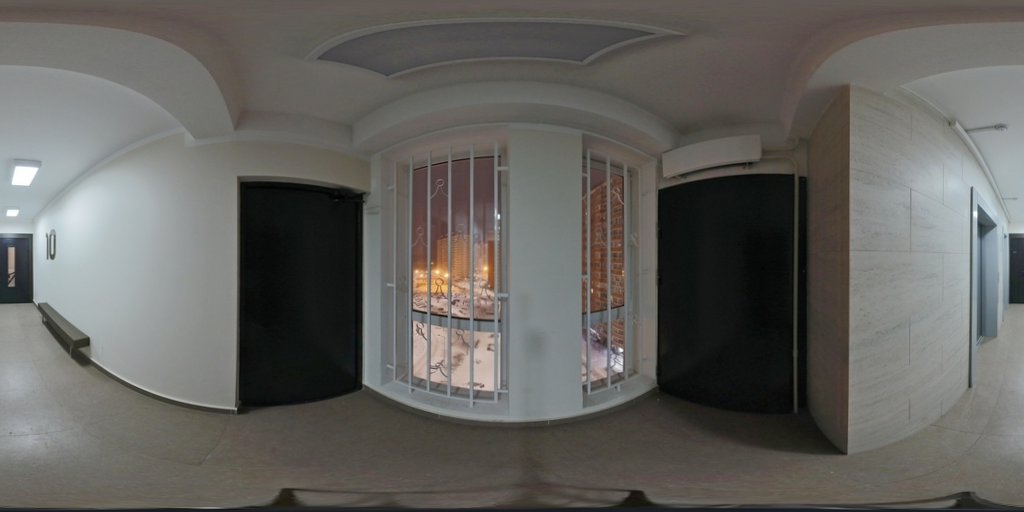

In [314]:
cv2_imshow(panorama_image)

In [315]:
walls_data

,walls
0,"[0, 0, 0, 2050]"
1,"[0, 0, 1640, 0]"
2,"[1640, 0, 1640, 400]"
3,"[1640, 400, 6020, 400]"
4,"[6020, 400, 6020, 2050]"
5,"[0, 2050, 6020, 2050]"


In [316]:
corners_vertical

array([[  30.914364,  222.41164 ],
       [  30.914364,  298.64883 ],
       [ 363.15613 ,  140.81924 ],
       [ 363.15613 ,  392.54047 ],
       [ 672.78357 ,  149.66058 ],
       [ 672.78357 ,  383.4991  ],
       [ 801.5895  ,  137.09825 ],
       [ 801.5895  ,  396.26495 ],
       [ 845.40314 ,   76.09795 ],
       [ 845.40314 ,  451.50623 ],
       [1008.1279  ,  221.95033 ],
       [1008.1279  ,  299.23853 ]], dtype=float32)

In [317]:
corners_horizontal

array([[221.67708, 221.43863, 221.38431, ..., 222.38773, 223.78665,
        223.0257 ],
       [299.86584, 298.79175, 299.72705, ..., 298.76703, 297.46896,
        299.3693 ]], dtype=float32)

[[1.2148892 1.2148892 1.2148892 ... 1.2148892 1.2148892 1.2148892]
 [1.2149348 1.2149348 1.2149348 ... 1.2149348 1.2149348 1.2149348]
 [1.2150264 1.2150264 1.2150264 ... 1.2150264 1.2150264 1.2150264]
 ...
 [1.6001883 1.6001883 1.6001883 ... 1.6001883 1.6001883 1.6001883]
 [1.6000677 1.6000677 1.6000677 ... 1.6000677 1.6000677 1.6000677]
 [1.6000075 1.6000075 1.6000075 ... 1.6000075 1.6000075 1.6000075]]


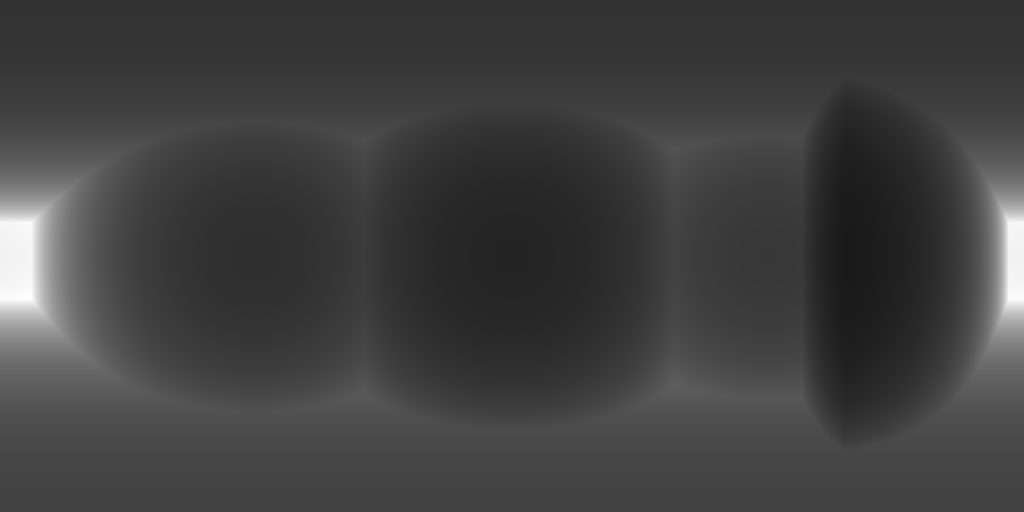

In [318]:
print(depth_map)
cv2_imshow(depth_map*255/depth_map.max())

Определите координаты ближайшей точки и самой дальней точки от места съемки фотографии на основе карты глубины.

In [319]:
farest_point = np.where(depth_map == depth_map.max())
nearest_point = np.where(depth_map == depth_map.min())
print(farest_point, nearest_point)

(array([298]), array([30])) (array([255, 256]), array([846, 846]))


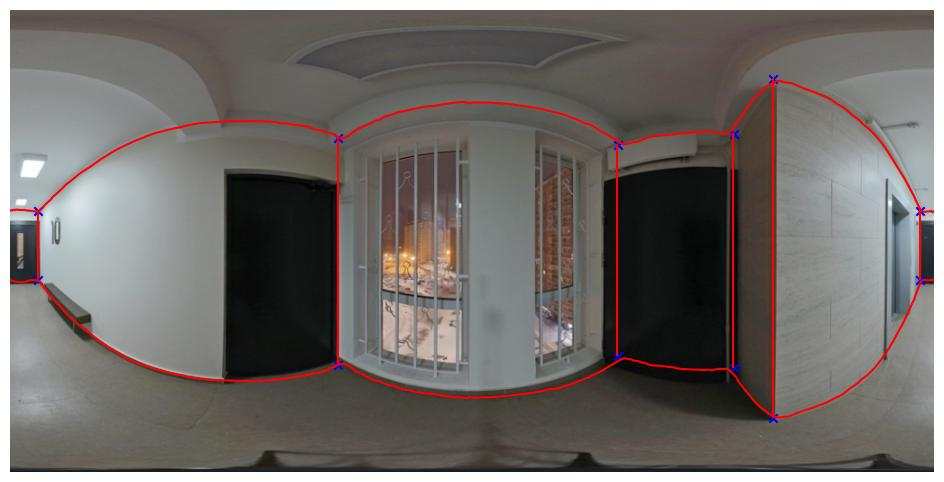

In [320]:
partition_image = cv2.imread("/content/drive/MyDrive/intern_test_3D_room-main/data/partition.jpg")
cv2_imshow(partition_image)


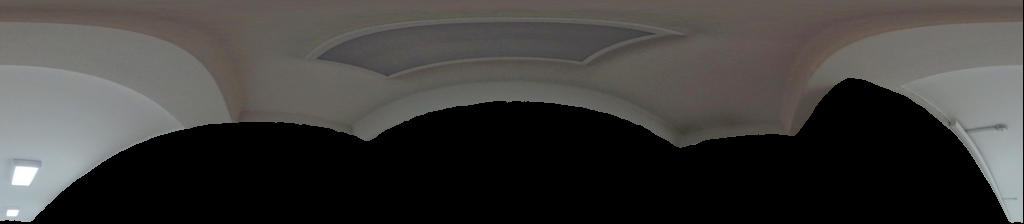

In [321]:
#Extract Ciel
Ciel = np.zeros(panorama_image.shape)
for col in range(panorama_image.shape[1]):
  for p in corners_horizontal[:1,:]:
    p= int(np.take(p,col))
    Ciel[:p,col-1:col,:] = panorama_image[:p,col-1:col,:]
p_max = int(np.take(corners_horizontal[:1,:].max(),0))
Ciel1 = Ciel[:p_max+1,:,:]
cv2_imshow(Ciel1)


In [322]:
Ciel1.shape

(224, 1024, 3)

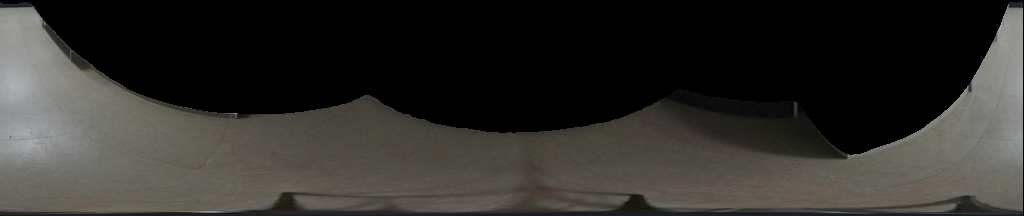

In [323]:
#Extract Ground
Ground = np.zeros(panorama_image.shape)
for col in range(panorama_image.shape[1]):
  for p in corners_horizontal[1:,:]:
    p= int(np.take(p,col))
    Ground[p:,col-1:col,:] = panorama_image[p:,col-1:col,:]
p_min = int(np.take(corners_horizontal[1:,:].min(),0))
Ground1 = Ground[p_min-1:,:,:]

cv2_imshow(Ground1)

In [324]:
boundary_coor = list(corners_vertical[::2][:,0])
boundary_coor = [0] +boundary_coor
for i,v in enumerate(boundary_coor):
  boundary_coor[i] = round(v)
boundary_coor

[0, 31, 363, 673, 802, 845, 1008]

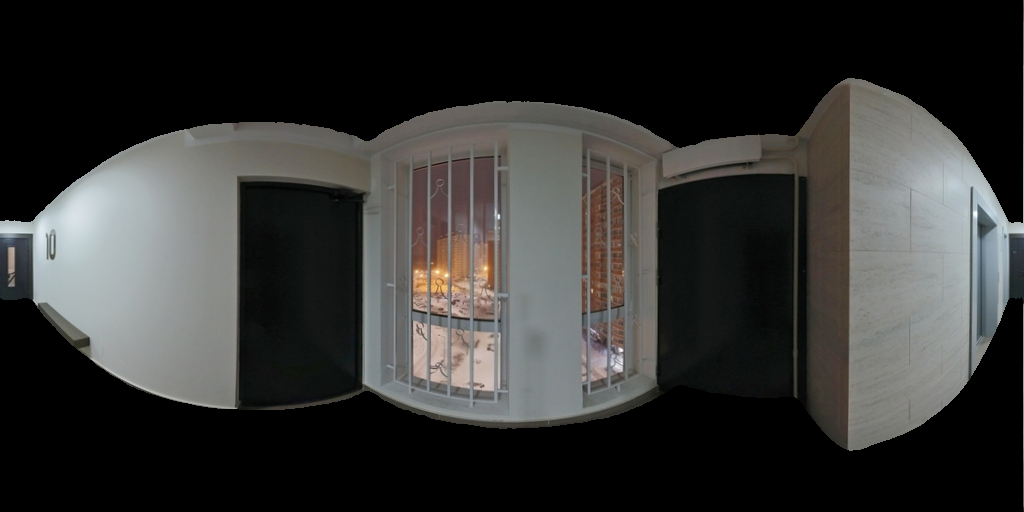

In [325]:
#Extract Walls
walls = panorama_image - Ciel - Ground
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/walls.png',walls)
cv2_imshow(walls)

In [326]:
Walls = {}
for i in range(1,len(boundary_coor)):
  if i < len(boundary_coor):
    Walls['wall'+str(i)] = walls[:,boundary_coor[i-1]:boundary_coor[i],:]
  else:
    Walls['wall'+str(len(boundary_coor))] = walls[:,boundary_coor[i]:,:]

Начало и конец данного панорамного изображения фактически связаны, и, таким образом, часть, оставшаяся после последней стены, добавляется к началу первой стены.

In [327]:
rest = walls[:,boundary_coor[-1]:-2,:]

In [328]:
cv2_imshow(rest)

In [329]:
wall_1 = np.concatenate((rest,Walls['wall1']), axis=1)

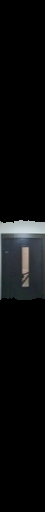

In [330]:
cv2_imshow(wall_1)

In [331]:
Walls['wall1'] = wall_1

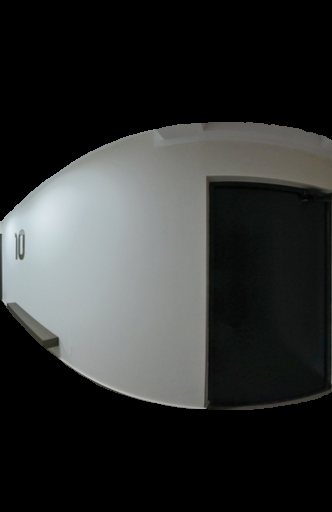

In [332]:
Wall2 = Walls['wall2']
cv2_imshow(Wall2)

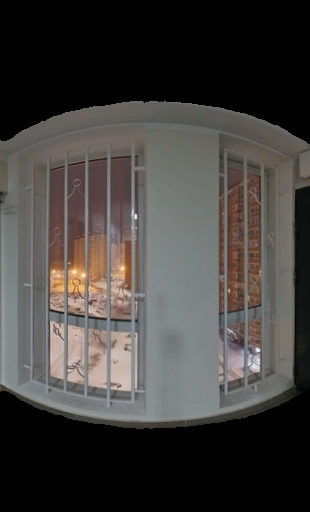

In [333]:
Wall3 = Walls['wall3']
cv2_imshow(Wall3)

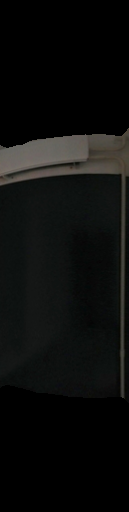

In [334]:
Wall4 = Walls['wall4']
cv2_imshow(Wall4)

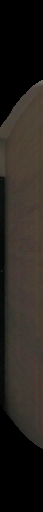

In [335]:
Wall5 = Walls['wall5']
cv2_imshow(Wall5)

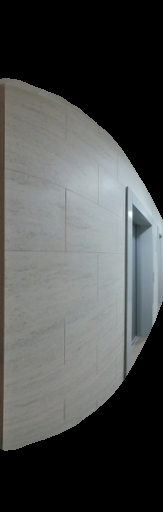

In [336]:
Wall6 = Walls['wall6']
cv2_imshow(Wall6)

In [337]:
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/Ciel.png',Ciel)
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/Floor.png',Ground)
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/wall1.png',wall_1)
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/wall2.png',Wall2)
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/wall3.png',Wall3)
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/wall4.png',Wall4)
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/wall5.png',Wall5)
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/wall6.png',Wall6)

True

Функция расчета самой широкой области маски изображения для определения верхней и нижней точек мест, которые образуют вертикальное расширение изображения стены.

In [338]:
def widest_area (img):
  wide = 0
  idx = 0
  for col in range(img.shape[1]):
    if img[:,col].sum() > wide:
      wide = img[:,col].sum()
      idx = col
  nonzer = np.nonzero(img[:,idx])
  top_n, bottom_n = nonzer[0][0], nonzer[0][-1]
  return idx,top_n, bottom_n

Функция расчета самой узкой области в маске изображения для определения верхней и нижней точек в матрице преобразования.

In [339]:
def narrowest_area (img):
  narrow = 255*img.shape[0]
  idx = 0
  for col in range(img.shape[1]):
    if img[:,col].sum() < narrow:
      narrow = img[:,col].sum()
      idx = col
  nonzer = np.nonzero(img[:,idx])
  top_w, bottom_w = nonzer[0][0], nonzer[0][-1]
  return idx, top_w, bottom_w

Так, чтобы размеры полученных проекций были эквивалентны реальным размерам лифтового вестибюля, а так как ширина панорамного изображения эквивалентна периметру помещения, то соотношение сторон проекций извлеченных изображений будет рассчитывается исходя из отношения размеров каждой стены к периметру помещения.

In [340]:
#Finding the dimensional ratios between the panoramic image and the actual dimensions
walls_heigth = 2500
wall1_W = 1650
wall2_W = 6020
wall3_W = 2050
wall4_W = 1640
wall5_W = 1300
wall6_W = wall2_W - wall4_W - wall5_W
Room_circumference = wall1_W + wall2_W + wall3_W  +wall4_W + wall5_W + wall6_W
wedth_rates =[]
for i,W in enumerate([wall1_W, wall2_W, wall3_W, wall4_W, wall5_W, wall6_W]):
  wedth_rates.append(Room_circumference/W)


In [341]:
for i,v in enumerate(wedth_rates):
  wedth_rates[i]= round(v)
wedth_rates

[10, 3, 8, 10, 12, 5]

In [342]:
img = cv2.imread('/content/drive/MyDrive/intern_test_3D_room-main/data/wall2.png', cv2.IMREAD_GRAYSCALE)
ret,bi_mask_wall = cv2.threshold(img,3,255,cv2.THRESH_BINARY)
narrowest_area(bi_mask_wall)

(0, 221, 299)


Projection of wall1



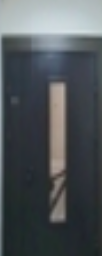


Projection of wall2



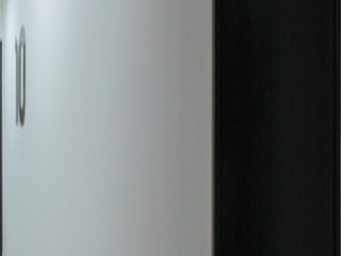


Projection of wall3



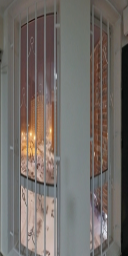


Projection of wall4



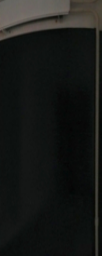


Projection of wall5



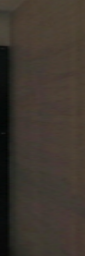


Projection of wall6



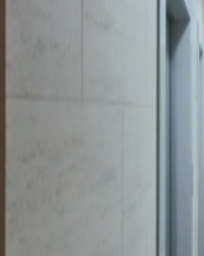

In [343]:
for (k,v),i in zip(Walls.items(),wedth_rates):
  bi_mask_wall = cv2.imread('/content/drive/MyDrive/intern_test_3D_room-main/data/'+str(k)+'.png', cv2.IMREAD_GRAYSCALE)
  ret,bi_mask_wall = cv2.threshold(bi_mask_wall,5,255,cv2.THRESH_BINARY)
  positions = np.nonzero(bi_mask_wall)
  _,top, bottom = narrowest_area(bi_mask_wall)
  left = positions[1].min()
  right = positions[1].max()
  p1 = (left,top)
  p2 = (right, top)
  p3 = (right, bottom)
  p4 = (left, bottom)

  Heigth = panorama_image.shape[0]//2
  Width = panorama_image.shape[1]//i
  input_pts = np.float32([p1, p4, p3, p2])
  output_pts = np.float32([[0, 0],
                        [0, Heigth - 1],
                        [Width - 1, Heigth - 1],
                        [Width - 1, 0]])
  M = cv2.getPerspectiveTransform(input_pts,output_pts)
  projection = cv2.warpPerspective(v,M,(Width, Heigth),flags=cv2.INTER_LINEAR)
  print('\nProjection of '+str(k)+'\n')
  cv2_imshow(projection)

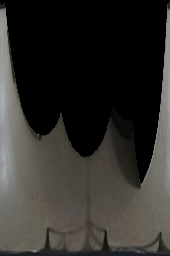

In [344]:
Ground_1 = cv2.resize(Ground1,(panorama_image.shape[1]//6, panorama_image.shape[0]//2))
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/Floor1.png', Ground_1)
cv2_imshow(Ground_1)

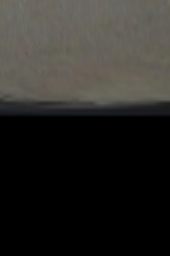

In [345]:
bi_mask_wall = cv2.imread('/content/drive/MyDrive/intern_test_3D_room-main/data/Floor1.png', cv2.IMREAD_GRAYSCALE)
ret,bi_mask_wall = cv2.threshold(bi_mask_wall,5,255,cv2.THRESH_BINARY)
positions = np.nonzero(bi_mask_wall)
_,top, bottom = narrowest_area(bi_mask_wall)
left = positions[1].min()
right = positions[1].max()
p1 = (left,top)
p2 = (right, top)
p3 = (right, bottom)
p4 = (left, bottom)

Heigth = panorama_image.shape[0]//2
Width = panorama_image.shape[1]//6
input_pts = np.float32([p1, p4, p3, p2])
output_pts = np.float32([[0, 0],
                        [0, Heigth - 1],
                        [Width - 1, Heigth - 1],
                        [Width - 1, 0]])
M = cv2.getPerspectiveTransform(input_pts,output_pts)
projection = cv2.warpPerspective(Ground1,M,(Width, Heigth),flags=cv2.INTER_LINEAR)
cv2_imshow(projection)

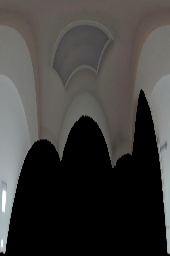

In [346]:
Ciel_1 = cv2.resize(Ciel1,(panorama_image.shape[1]//6, panorama_image.shape[0]//2))
cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/Ciel1.png', Ground_1)
cv2_imshow(Ciel_1)


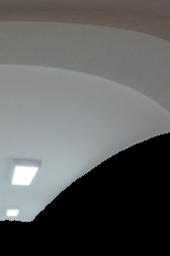

In [347]:
bi_mask_wall = cv2.imread('/content/drive/MyDrive/intern_test_3D_room-main/data/Ciel1.png', cv2.IMREAD_GRAYSCALE)
ret,bi_mask_wall = cv2.threshold(bi_mask_wall,2,255,cv2.THRESH_BINARY)
positions = np.nonzero(bi_mask_wall)
_,top, bottom = widest_area(bi_mask_wall)
left = positions[1].min()
right = positions[1].max()
p1 = (left,top)
p2 = (right, top)
p3 = (right, bottom)
p4 = (left, bottom)

Heigth = panorama_image.shape[0]//2
Width = panorama_image.shape[1]//6
input_pts = np.float32([p1, p4, p3, p2])
output_pts = np.float32([[0, 0],
                        [0, Heigth - 1],
                        [Width - 1, Heigth - 1],
                        [Width - 1, 0]])
M = cv2.getPerspectiveTransform(input_pts,output_pts)
projection = cv2.warpPerspective(Ciel1,M,(Width, Heigth),flags=cv2.INTER_LINEAR)
cv2_imshow(projection)

##Другой алгоритм
основан на сегментировании крыши аналогично процессу сегментирования стен, нахождении проекции каждой части отдельно, а затем сборе выступов вместе.

In [348]:
Ciel_pieces = {}
for i in range(1,len(boundary_coor)):
  if i < len(boundary_coor):
    Ciel_pieces['wall'+str(i)] = Ciel1[:,boundary_coor[i-1]:boundary_coor[i],:]
  else:
    Ciel_pieces['wall'+str(len(boundary_coor))] = Ciel1[:,boundary_coor[i]:,:]

Ciel_rest = Ciel1[:,boundary_coor[-1]:-2,:]
Ciel_pieces['wall1'] = np.concatenate((Ciel_rest,Ciel_pieces['wall1']), axis=1)

In [349]:
for k,v in Ciel_pieces.items() :
  cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/Ciel_'+str(k)+'.png', v)


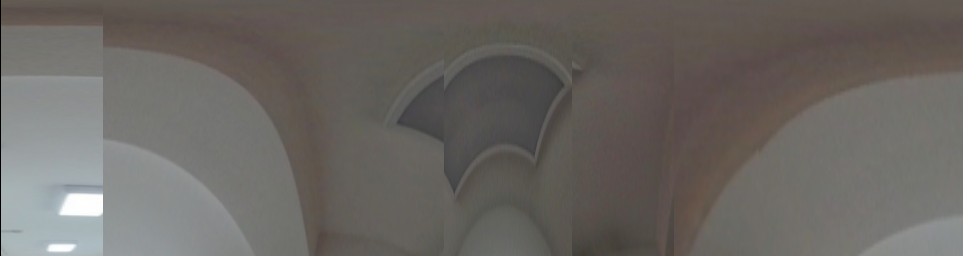

In [350]:
Ciel_projection = np.zeros((panorama_image.shape[0]//2,1,Ciel1.shape[2]))
for (k,v),i in zip(Ciel_pieces.items(),wedth_rates):
  bi_mask_wall = cv2.imread('/content/drive/MyDrive/intern_test_3D_room-main/data/Ciel_'+str(k)+'.png', cv2.IMREAD_GRAYSCALE)
  ret,bi_mask_wall = cv2.threshold(bi_mask_wall,5,255,cv2.THRESH_BINARY)
  positions = np.nonzero(bi_mask_wall)
  _,top, bottom = narrowest_area(bi_mask_wall)
  left = positions[1].min()
  right = positions[1].max()
  p1 = (left,top)
  p2 = (right, top)
  p3 = (right, bottom)
  p4 = (left, bottom)

  Heigth = panorama_image.shape[0]//2
  Width = panorama_image.shape[1]//i
  input_pts = np.float32([p1, p4, p3, p2])
  output_pts = np.float32([[0, 0],
                        [0, Heigth - 1],
                        [Width - 1, Heigth - 1],
                        [Width - 1, 0]])
  M = cv2.getPerspectiveTransform(input_pts,output_pts)
  projection = cv2.warpPerspective(v,M,(Width, Heigth),flags=cv2.INTER_LINEAR)
  Ciel_projection = np.concatenate((Ciel_projection,projection), axis=1)


cv2_imshow(Ciel_projection)

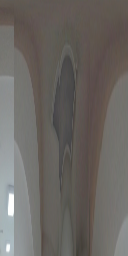

In [351]:
Ciel_projection = cv2.resize(Ciel_projection,(panorama_image.shape[1]//8, panorama_image.shape[0]//2))
#cv2.imwrite('/content/drive/MyDrive/intern_test_3D_room-main/data/Floor1.png', Ground_1)
cv2_imshow(Ciel_projection)

Я пробовал использовать фотосшивку для сборки деталей потолка, но не получилось, так как появились некоторые ошибки и у меня не было времени их исправить.

In [352]:
'''stitcher =cv2.Stitcher_create()
foo = cv2.imread('/content/drive/MyDrive/intern_test_3D_room-main/data/Ciel_projection0.png', cv2.IMREAD_GRAYSCALE)
bar = cv2.imread('/content/drive/MyDrive/intern_test_3D_room-main/data/Ciel_projection1.png', cv2.IMREAD_GRAYSCALE)
status, result = stitcher.stitch((foo,bar))
cv2_imshow("Stitched", result) # display stitched image'''



'stitcher =cv2.Stitcher_create()\nfoo = cv2.imread(\'/content/drive/MyDrive/intern_test_3D_room-main/data/Ciel_projection0.png\', cv2.IMREAD_GRAYSCALE)\nbar = cv2.imread(\'/content/drive/MyDrive/intern_test_3D_room-main/data/Ciel_projection1.png\', cv2.IMREAD_GRAYSCALE)\nstatus, result = stitcher.stitch((foo,bar))\ncv2_imshow("Stitched", result) # display stitched image'